In [1]:
import chromadb
#https://github.com/chroma-core/chroma/blob/main/chromadb/experimental/density_relevance.ipynb

client =  chromadb.PersistentClient('./chroma_docs')
col_raw = client.get_collection('documents_raw')
col_summary = client.get_collection('documents_summary')
data_raw = col_raw.get()
data = col_summary.get()

print(data.keys())
documents = data['documents']
documents_raw = data_raw['documents']
len(data['documents'])


dict_keys(['ids', 'embeddings', 'metadatas', 'documents', 'uris', 'data', 'included'])


3231

In [2]:
from sentence_transformers import SentenceTransformer
import pandas as pd

embedding = SentenceTransformer("all-MiniLM-L6-v2")


/proj/ciptmp/ix05ogym/myenv/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

No ROCm runtime is found, using ROCM_HOME='/usr'


In [3]:
test_path = '/home/cip/ce/ix05ogym/Majid/LLM/GraphRag/elec_graph/input/'
#pd.DataFrame({"id":data['ids'],"text":data['documents']}).iloc[0:1,:].to_csv(test_path+'test.csv')
f = pd.DataFrame({"id":data_raw['ids'],"text":data_raw['documents']}).iloc[0:100]
f.to_csv(test_path+'scholar_raw.csv')
f

,id,text
0,2402.05930v1.pdf_0,4\n\n2024\n\n2\n\n0\n\n2\n\nb e F 8 ] L C . s ...
1,2402.05930v1.pdf_1,1 Introduction\n\nProprietary conversational a...
2,2402.05930v1.pdf_2,"websites through a chat interface, enhancing s..."
3,2402.05930v1.pdf_3,We examine 19 models based on 8 architectures ...
4,2402.05930v1.pdf_4,Figure 2: Distribution of demonstrations in WE...
...,...,...
95,2405.16506v1.pdf_table_0,Dataset # Graphs # Nodes # Edges # Tokens WebQ...
96,2405.16506v1.pdf_table_1,Model Φ(g) Fine-tuning F1 Score Hit@1 Recall A...
97,2405.16506v1.pdf_table_2,Setting Hit@1 ∆GRAG w/o Retrieval 0.6093 ↓ 16....
98,2405.16506v1.pdf_table_3,Model top-3 top-5 top-10 top-15 top-20 top-3 t...


In [15]:
documents =pd.read_csv('/home/cip/ce/ix05ogym/Majid/LLM/GraphRag/elec_graph/input/soldering.csv')['text'].tolist()
documents

["6G a®*: s +. i 2 a <, s e Ged SECOND EDITION\n\nSoldering in Electronics Assembly\n\nThis Page Intentionally Left Blank\n\nSoldering in Electronics Assembly   Mike Judd and Keith Brindley   Newnes  \n\nNewnes\n\nNewnes An imprint of Butterworth-Heinemann Linacre House, Jordan Hill, Oxford OX2 8DP 225 Wildwood Avenue, Woburn, MA 01801-2041 A division of Reed Educationa and Professional Publishing Ltd RQ A member of the Reed Elsevier plc group First published 1992 Second edition 1999 © Mike Judd & Keith Brindley 1992, 1999 All rights reserved. No part of this publication may be reproduced in any material form (including photocopying or storing in any medium by electronic Means and whether or not transiently or incidentally to some other use of this publication) without the written permission of the copyright holders except in accordance with the provisions of the Copyright, Design and Patents Act 1988 or under the terms of a licence issued by the Copyright Licensing Agency Ltd, 90 Tott

In [16]:
from top2vec import Top2Vec

t2v = Top2Vec(documents=documents,embedding_model=embedding.encode)

2024-11-10 18:51:22,405 - top2vec - INFO - Pre-processing documents for training
2024-11-10 18:51:22,416 - top2vec - INFO - Creating joint document/word embedding
2024-11-10 18:51:22,459 - top2vec - INFO - Creating lower dimension embedding of documents
2024-11-10 18:51:23,167 - top2vec - INFO - Finding dense areas of documents
2024-11-10 18:51:23,168 - top2vec - INFO - Finding topics


ValueError: need at least one array to concatenate

In [5]:
t2v_topics , score , id = t2v.get_topics()

print(list(zip(t2v_topics,score)))


[(array(['benchmarks', 'benchmark', 'performance', 'accuracy', 'ranking',
       'models', 'precision', 'corpus', 'table', 'model', 'evaluation',
       'retrieval', 'processing', 'datasets', 'supervised', 'scores',
       'improvements', 'structured', 'languages', 'results', 'tasks',
       'computational', 'language', 'multilingual', 'improving',
       'modeling', 'semantic', 'compares', 'features', 'database',
       'improved', 'textual', 'intelligence', 'dataset', 'comparing',
       'ai', 'classification', 'improvement', 'tools', 'adaptive',
       'metrics', 'encoding', 'efficiency', 'texts', 'evaluating',
       'specialized', 'speed', 'efficient', 'significantly', 'faster'],
      dtype='<U15'), array([0.53098994, 0.5272269 , 0.51062846, 0.4787996 , 0.4308035 ,
       0.4266767 , 0.39595667, 0.37777498, 0.37645662, 0.37640136,
       0.3739558 , 0.37125233, 0.35491163, 0.3538318 , 0.34634495,
       0.34214613, 0.3408568 , 0.33893323, 0.3371194 , 0.33679652,
       0.33670676

In [6]:
for i in range(5):
    print(t2v_topics[t2v.doc_top[i]][:5])
    print(documents[i])
    pass

for t in t2v_topics:
    t2v_labels= '_'.join(t[:5])
    print(t2v_labels)

['instruction' 'languages' 'language' 'corpus' 'programming']
This text describes a new large language model (LLM) called WizardLM. WizardLM is trained on a large dataset of instructions generated by an AI system called Evol-Instruct. Evol-Instruct creates complex instructions by gradually rewriting simpler ones. The researchers found that instructions generated by Evol-Instruct are better than those created by humans. WizardLM outperforms OpenAI's ChatGPT in some tasks, demonstrating the potential of AI-evolved instructions for improving LLMs. The code and data for WizardLM are publicly available. 

['instruction' 'languages' 'language' 'corpus' 'programming']
This paper introduces Evol-Instruct, a method for automatically generating open-domain instructions of varying difficulty levels using LLMs. This addresses the limitations of human-generated instruction datasets, which are expensive, time-consuming, and skewed towards easier instructions. Evol-Instruct uses two main strategies: 

In [25]:
len(data['documents'])
len(documents)
documents = data['documents']

In [26]:
from bertopic import BERTopic
bt = BERTopic()
documents_embedding = embedding.encode(documents)
topics, probs = bt.fit_transform(documents=documents,embeddings=documents_embedding)
bt.get_topic_info()
bt.visualize_topics()
hierarchical_topics = bt.hierarchical_topics(documents)
bt.visualize_hierarchy(hierarchical_topics=hierarchical_topics)


100%|██████████| 86/86 [00:00<00:00, 763.45it/s]


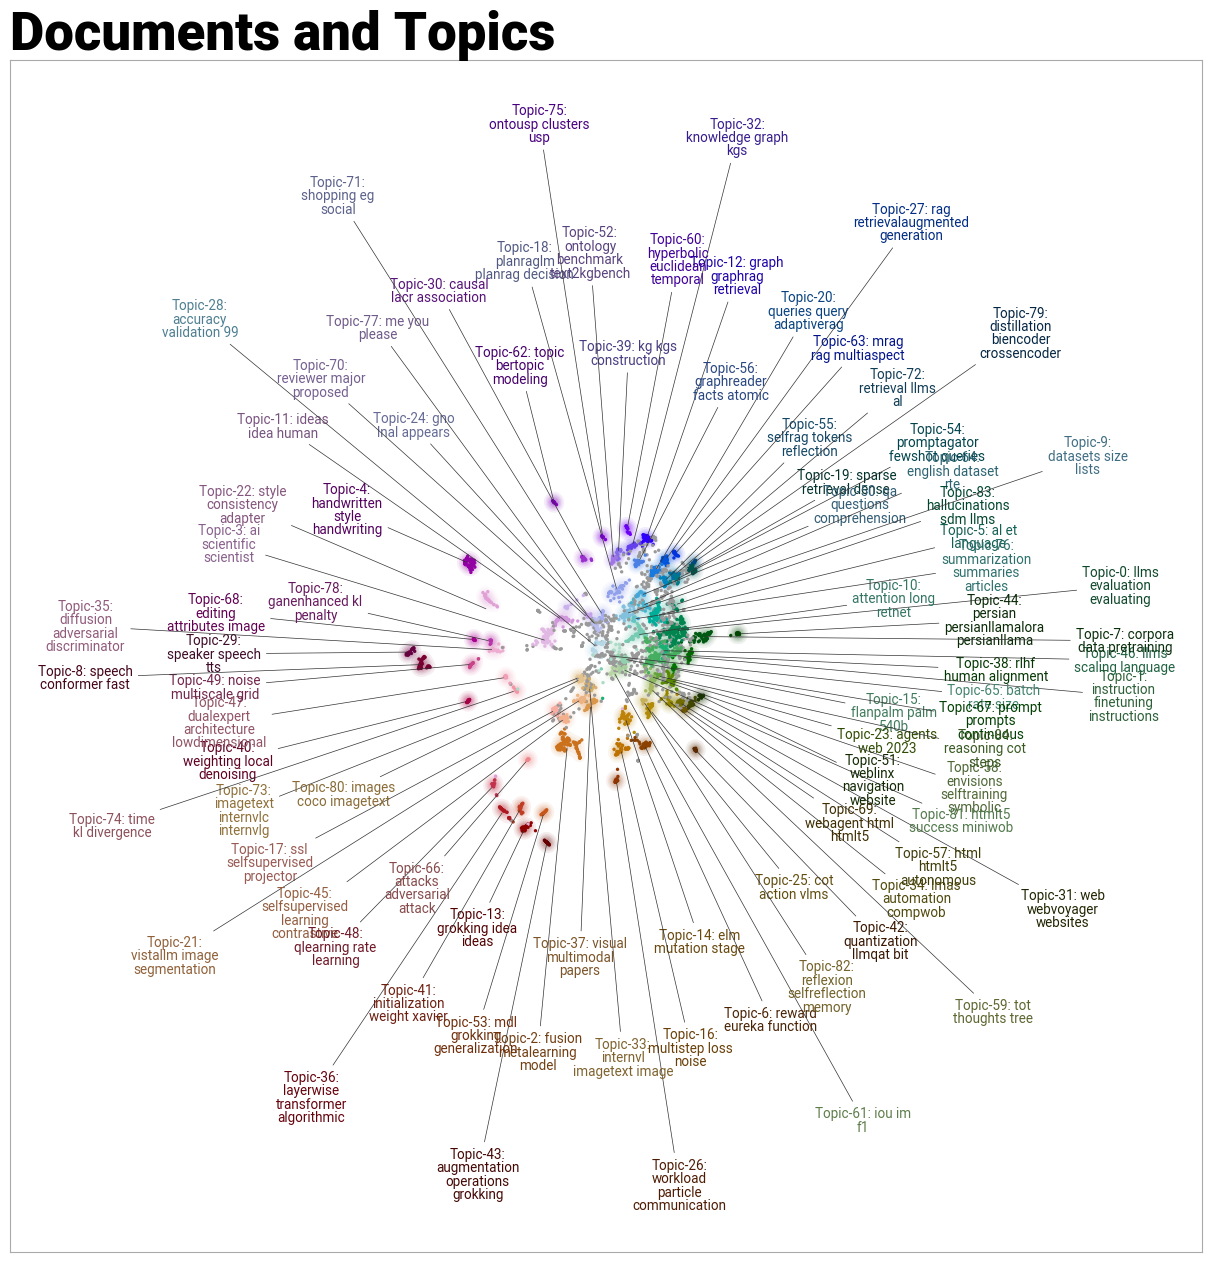

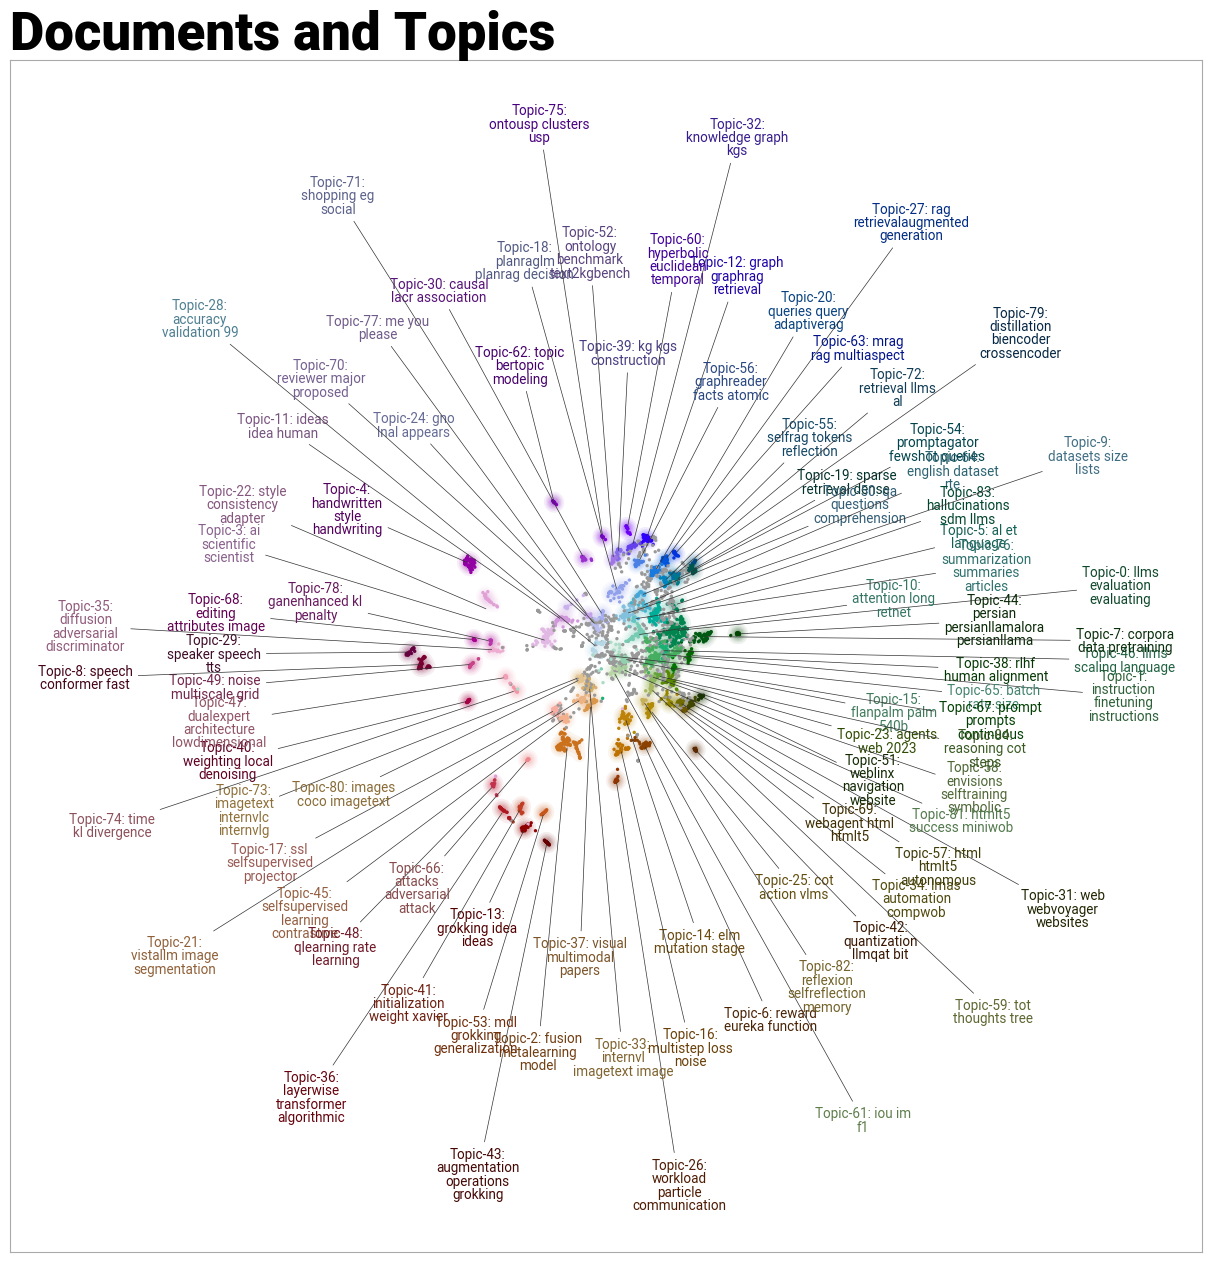

In [8]:
bt.visualize_document_datamap(documents,topics,documents_embedding)


In [9]:
bt.visualize_topics()

In [10]:
import datamapplot
from umap import UMAP

umap_model = UMAP(n_neighbors=15, n_components=2, min_dist=0.15, metric='cosine').fit(documents_embedding)
embeddings_2d = umap_model.embedding_


"""width = 1200
height = 1200
figure, axes = datamapplot.create_plot(
        embeddings_2d,
        num
        figsize=(width/100, height/100),
        dpi=100,
        title="title",
        sub_title="sub_title",
    )"""


'width = 1200\nheight = 1200\nfigure, axes = datamapplot.create_plot(\n        embeddings_2d,\n        num\n        figsize=(width/100, height/100),\n        dpi=100,\n        title="title",\n        sub_title="sub_title",\n    )'

In [11]:
from utils import sys_msg,completion

sys_msg = "You are an expert ontology and entity designer."

prompt ="""Exctract entities, types, relationships for the following document.
{text}
"""
text = ""
for i,d in enumerate(documents[:5]):
    text += f"""### {i}:\n{d.strip()}\n"""
    break

prompt = prompt.format(text=text)
print(prompt)

ImportError: cannot import name 'sys_msg' from 'utils' (/home/cip/ce/ix05ogym/Majid/LLM/GraphRag/utils.py)

In [ ]:
completion(prompt)

In [ ]:
from graphrag.index.graph.extractors.graph.graph_extractor import GraphExtractor

e = GraphExtractor(completion,)


In [ ]:

#One of the following types: [{entity_types}]
entity_prompt = """
-Goal-
Given a text document that is potentially relevant to this activity and a list of entity types, identify all entities of those types from the text and all relationships among the identified entities.
 
-Steps-
1. Identify all entities. For each identified entity, extract the following information:
- entity_name: Name of the entity, capitalized
- entity_type: Type of the entity
- entity_description: Comprehensive description of the entity's attributes and activities
Format each entity as ("entity"{tuple_delimiter}<entity_name>{tuple_delimiter}<entity_type>{tuple_delimiter}<entity_description>)
 
2. From the entities identified in step 1, identify all pairs of (source_entity, target_entity) that are *clearly related* to each other.
For each pair of related entities, extract the following information:
- source_entity: name of the source entity, as identified in step 1
- target_entity: name of the target entity, as identified in step 1
- relationship_description: explanation as to why you think the source entity and the target entity are related to each other
- relationship_strength: a numeric score indicating strength of the relationship between the source entity and target entity
 Format each relationship as ("relationship"{tuple_delimiter}<source_entity>{tuple_delimiter}<target_entity>{tuple_delimiter}<relationship_description>{tuple_delimiter}<relationship_strength>)
 
3. Return output in English as a single list of all the entities and relationships identified in steps 1 and 2. Use **{record_delimiter}** as the list delimiter.
 
4. When finished, output {completion_delimiter}

-Real Data-
######################
Entity_types: {entity_types}
Text: {input_text}
######################
Output:"""

EXAMPLE = """######################
-Examples-
######################
Example 1:
Entity_types: ORGANIZATION,PERSON
Text:
The Verdantis's Central Institution is scheduled to meet on Monday and Thursday, with the institution planning to release its latest policy decision on Thursday at 1:30 p.m. PDT, followed by a press conference where Central Institution Chair Martin Smith will take questions. Investors expect the Market Strategy Committee to hold its benchmark interest rate steady in a range of 3.5%-3.75%.
######################
Output:
("entity"{tuple_delimiter}CENTRAL INSTITUTION{tuple_delimiter}ORGANIZATION{tuple_delimiter}The Central Institution is the Federal Reserve of Verdantis, which is setting interest rates on Monday and Thursday)
{record_delimiter}
("entity"{tuple_delimiter}MARTIN SMITH{tuple_delimiter}PERSON{tuple_delimiter}Martin Smith is the chair of the Central Institution)
{record_delimiter}
("entity"{tuple_delimiter}MARKET STRATEGY COMMITTEE{tuple_delimiter}ORGANIZATION{tuple_delimiter}The Central Institution committee makes key decisions about interest rates and the growth of Verdantis's money supply)
{record_delimiter}
("relationship"{tuple_delimiter}MARTIN SMITH{tuple_delimiter}CENTRAL INSTITUTION{tuple_delimiter}Martin Smith is the Chair of the Central Institution and will answer questions at a press conference{tuple_delimiter}9)
{completion_delimiter}

######################
Example 2:
Entity_types: ORGANIZATION
Text:
TechGlobal's (TG) stock skyrocketed in its opening day on the Global Exchange Thursday. But IPO experts warn that the semiconductor corporation's debut on the public markets isn't indicative of how other newly listed companies may perform.

TechGlobal, a formerly public company, was taken private by Vision Holdings in 2014. The well-established chip designer says it powers 85% of premium smartphones.
######################
Output:
("entity"{tuple_delimiter}TECHGLOBAL{tuple_delimiter}ORGANIZATION{tuple_delimiter}TechGlobal is a stock now listed on the Global Exchange which powers 85% of premium smartphones)
{record_delimiter}
("entity"{tuple_delimiter}VISION HOLDINGS{tuple_delimiter}ORGANIZATION{tuple_delimiter}Vision Holdings is a firm that previously owned TechGlobal)
{record_delimiter}
("relationship"{tuple_delimiter}TECHGLOBAL{tuple_delimiter}VISION HOLDINGS{tuple_delimiter}Vision Holdings formerly owned TechGlobal from 2014 until present{tuple_delimiter}5)
{completion_delimiter}

######################
Example 3:
Entity_types: ORGANIZATION,GEO,PERSON
Text:
Five Aurelians jailed for 8 years in Firuzabad and widely regarded as hostages are on their way home to Aurelia.

The swap orchestrated by Quintara was finalized when $8bn of Firuzi funds were transferred to financial institutions in Krohaara, the capital of Quintara.

The exchange initiated in Firuzabad's capital, Tiruzia, led to the four men and one woman, who are also Firuzi nationals, boarding a chartered flight to Krohaara.

They were welcomed by senior Aurelian officials and are now on their way to Aurelia's capital, Cashion.

The Aurelians include 39-year-old businessman Samuel Namara, who has been held in Tiruzia's Alhamia Prison, as well as journalist Durke Bataglani, 59, and environmentalist Meggie Tazbah, 53, who also holds Bratinas nationality.
######################
Output:
("entity"{tuple_delimiter}FIRUZABAD{tuple_delimiter}GEO{tuple_delimiter}Firuzabad held Aurelians as hostages)
{record_delimiter}
("entity"{tuple_delimiter}AURELIA{tuple_delimiter}GEO{tuple_delimiter}Country seeking to release hostages)
{record_delimiter}
("entity"{tuple_delimiter}QUINTARA{tuple_delimiter}GEO{tuple_delimiter}Country that negotiated a swap of money in exchange for hostages)
{record_delimiter}
{record_delimiter}
("entity"{tuple_delimiter}TIRUZIA{tuple_delimiter}GEO{tuple_delimiter}Capital of Firuzabad where the Aurelians were being held)
{record_delimiter}
("entity"{tuple_delimiter}KROHAARA{tuple_delimiter}GEO{tuple_delimiter}Capital city in Quintara)
{record_delimiter}
("entity"{tuple_delimiter}CASHION{tuple_delimiter}GEO{tuple_delimiter}Capital city in Aurelia)
{record_delimiter}
("entity"{tuple_delimiter}SAMUEL NAMARA{tuple_delimiter}PERSON{tuple_delimiter}Aurelian who spent time in Tiruzia's Alhamia Prison)
{record_delimiter}
("entity"{tuple_delimiter}ALHAMIA PRISON{tuple_delimiter}GEO{tuple_delimiter}Prison in Tiruzia)
{record_delimiter}
("entity"{tuple_delimiter}DURKE BATAGLANI{tuple_delimiter}PERSON{tuple_delimiter}Aurelian journalist who was held hostage)
{record_delimiter}
("entity"{tuple_delimiter}MEGGIE TAZBAH{tuple_delimiter}PERSON{tuple_delimiter}Bratinas national and environmentalist who was held hostage)
{record_delimiter}
("relationship"{tuple_delimiter}FIRUZABAD{tuple_delimiter}AURELIA{tuple_delimiter}Firuzabad negotiated a hostage exchange with Aurelia{tuple_delimiter}2)
{record_delimiter}
("relationship"{tuple_delimiter}QUINTARA{tuple_delimiter}AURELIA{tuple_delimiter}Quintara brokered the hostage exchange between Firuzabad and Aurelia{tuple_delimiter}2)
{record_delimiter}
("relationship"{tuple_delimiter}QUINTARA{tuple_delimiter}FIRUZABAD{tuple_delimiter}Quintara brokered the hostage exchange between Firuzabad and Aurelia{tuple_delimiter}2)
{record_delimiter}
("relationship"{tuple_delimiter}SAMUEL NAMARA{tuple_delimiter}ALHAMIA PRISON{tuple_delimiter}Samuel Namara was a prisoner at Alhamia prison{tuple_delimiter}8)
{record_delimiter}
("relationship"{tuple_delimiter}SAMUEL NAMARA{tuple_delimiter}MEGGIE TAZBAH{tuple_delimiter}Samuel Namara and Meggie Tazbah were exchanged in the same hostage release{tuple_delimiter}2)
{record_delimiter}
("relationship"{tuple_delimiter}SAMUEL NAMARA{tuple_delimiter}DURKE BATAGLANI{tuple_delimiter}Samuel Namara and Durke Bataglani were exchanged in the same hostage release{tuple_delimiter}2)
{record_delimiter}
("relationship"{tuple_delimiter}MEGGIE TAZBAH{tuple_delimiter}DURKE BATAGLANI{tuple_delimiter}Meggie Tazbah and Durke Bataglani were exchanged in the same hostage release{tuple_delimiter}2)
{record_delimiter}
("relationship"{tuple_delimiter}SAMUEL NAMARA{tuple_delimiter}FIRUZABAD{tuple_delimiter}Samuel Namara was a hostage in Firuzabad{tuple_delimiter}2)
{record_delimiter}
("relationship"{tuple_delimiter}MEGGIE TAZBAH{tuple_delimiter}FIRUZABAD{tuple_delimiter}Meggie Tazbah was a hostage in Firuzabad{tuple_delimiter}2)
{record_delimiter}
("relationship"{tuple_delimiter}DURKE BATAGLANI{tuple_delimiter}FIRUZABAD{tuple_delimiter}Durke Bataglani was a hostage in Firuzabad{tuple_delimiter}2)
{completion_delimiter}

###################### 
"""
DEFAULT_TUPLE_DELIMITER = "<|>"
DEFAULT_RECORD_DELIMITER = "##"
DEFAULT_COMPLETION_DELIMITER = "<|COMPLETE|>"
DEFAULT_ENTITY_TYPES = "everything" #["models","ways","casualty"]#["organization", "person", "geo", "event"]

entity_prompt = entity_prompt.format(record_delimiter=DEFAULT_RECORD_DELIMITER,
                     tuple_delimiter=DEFAULT_TUPLE_DELIMITER,
                     entity_types=DEFAULT_ENTITY_TYPES,
                     completion_delimiter = DEFAULT_COMPLETION_DELIMITER,
                     input_text=documents[0])

print(entity_prompt)


In [ ]:
entity_prompt = """
-Goal-
Given a text document that is potentially relevant to this activity and a list of entity types, identify all entities of those types from the text and all relationships among the identified entities.
 
-Steps-
1. Identify all entities. For each identified entity, extract the following information in JSON format:
entity:
- entity_name: Name of the entity, capitalized
- entity_type: Type of the entity
- entity_description: Comprehensive description of the entity's attributes and activities
 
2. From the entities identified in step 1, identify all pairs of (source_entity, target_entity) that are *clearly related* to each other.
For each pair of related entities, extract the following information:
relationship:
- source_entity: name of the source entity, as identified in step 1
- target_entity: name of the target entity, as identified in step 1
- relationship_description: explanation as to why you think the source entity and the target entity are related to each other
- relationship_strength: a numeric score indicating strength of the relationship between the source entity and target entity
 
3. Return output in English as a single list of all the entities and relationships identified in steps 1 and 2.
 
######################
Entity_types: {entity_types}
Text: {input_text}
######################
Output:"""

entity_prompt = entity_prompt.format(entity_types="Things",input_text=documents[0])
print(entity_prompt)


In [ ]:
results = completion(entity_prompt)
results

In [ ]:
results['relationships']

recounstract_prompt = """Give following entities and relashionships:
{entities}

What entities and relationships are missing to infere all the knowledge in the following text:
{orginal_document}

Output format in JSON:
'''JSON
need_more_entities: Yes or No
new_entities_list: a list of NEW entities
new_relationships: in case of Yes
""".format(entities= results['relationships'],orginal_document = documents[0])

print(recounstract_prompt)

In [ ]:
completion(recounstract_prompt)

In [ ]:
from graphrag.index import run_pipeline,cre